# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm
import uuid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


# Hyperparams

In [2]:
# root = os.getcwd()
# dataset =  os.path.join(root, 'dataset', 'amazon_full')
# #yelp polarity has 2 labels, 
# #yelp dataset has 5 labels, they have the same text content
# train_datapath = os.path.join(dataset, 'train.csv') 
# test_datapath = os.path.join(dataset, 'test.csv') 

# processed_train_dataset = os.path.join(dataset, 'processed_train_datset.pickle')
# processed_test_dataset = os.path.join(dataset, 'processed_test_dataset.pickle')
# vocab_save_path = os.path.join(dataset, 'vocab.pickle')

ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_train_5%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_test_1%.csv')

# model_save_root = os.path.join(root, 'output', 'transformer')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'lstm')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

id = str(uuid.uuid4()).split('-')[0]
EXP_NAME = f'baseline_{id}'

BATCH_SIZE = 64
MAX_SEQUENCE_LENGTH = 512

print(EXP_NAME)

baseline_0a6f2ec2


# Cleaning

In [3]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [4]:
train_df = pd.read_csv(CLEANED_TRAIN_DATAPATH)
NUM_CLASSES = len(train_df['review'].unique())
test_df = pd.read_csv(CLEANED_TEST_DATAPATH)
print(NUM_CLASSES)

5


# Prepare data

In [5]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 800):
    X_tokens = []
    X_lengths = []
    max_len = 0
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        max_len = max(max_len, len(tokens))
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    print('max len = ', max_len)
    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id


In [6]:
# all_df = pd.concat([train_df, test_df])
# all_df['text'] = all_df['text'].apply(lambda s: clean_text(s))

In [7]:
X_array = train_df['text'].values
y_array = train_df['review'].values

(train_tokens, train_ids, train_y, train_lengths) ,vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y values = ', set(train_y.tolist()) )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

#Test
test_X_array = test_df['text'].values
test_y_array = test_df['review'].values

(test_tokens, test_ids, test_y, test_lengths) ,_, _ = build_train_test_data(test_X_array, test_y_array)

test_ids = pad_sequence(test_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', test_ids.shape )
print('y values = ', set(test_y.tolist()) )
print('y shape = ', test_y.shape )
print('lengths shape = ', test_lengths.shape)

100%|██████████| 149992/149992 [00:07<00:00, 21151.42it/s]


max len =  405
vocab len =  75299


100%|██████████| 149992/149992 [00:04<00:00, 30605.18it/s]


ids shape =  torch.Size([149992, 405])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([149992])
lengths shape =  torch.Size([149992])


100%|██████████| 6499/6499 [00:00<00:00, 21385.94it/s]


max len =  250
vocab len =  13715


100%|██████████| 6499/6499 [00:00<00:00, 34587.14it/s]

ids shape =  torch.Size([6499, 250])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([6499])
lengths shape =  torch.Size([6499])


In [8]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=1
tokens=['i', 'was', 'terribly', 'disappointed', 'to', 'find', 'that', 'the', 'verb', 'drills', 'on', 'these', 'cds', 'do', 'not', 'include', 'the', 'informal', '2d', 'person', 'plural', 'vosotros', ',', 'as', 'used', 'in', 'spain', 'and', ',', 'just', 'as', 'importantly', ',', 'in', 'much', 'classic', 'spanish', 'literature', '.', 'i', 'see', 'no', 'point', 'in', 'learning', 'some', 'forms', 'of', 'each', 'tense', 'and', 'mood', 'of', 'verbs', 'and', 'not', 'all', 'of', 'them', '.', 'on', 'the', 'other', 'hand', ',', 'it', 'is', 'true', 'that', 'the', 'vosotros', 'form', 'is', 'almost', 'never', 'used', 'in', 'the', 'americas', ',', 'so', 'i', 'suppose', 'this', 'is', 'helpful', 'material', 'for', 'those', 'who', 'want', 'to', 'learn', 'spanish', 'only', 'for', 'use', 'in', ',', 'say', ',', 'mexico', 'or', 'guatemala', '.', 'but', 'why', 'do', 'that', '?', 'if', 'you', 'decide', 'you', 'want', 'to', 'anyway', ',', 'this', 'is', 'pure', 'drill', 'material', ',', 'and', 'if', 'yo

# Model

In [9]:
class LSTM(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_id,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

# Dataset

In [10]:
class YelpReview(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]


In [11]:
train_dataset = YelpReview(train_ids, train_y, train_lengths)
test_dataset = YelpReview(test_ids, test_y, test_lengths)

print(train_dataset)
print(vocab)
print(len(vocab))

NUM_CLASSES = len(set(train_dataset.labels.tolist()))
print('num classes = ', NUM_CLASSES)

# print(train_dataset)

# Save the YelpDataset

# with open(processed_train_dataset, 'wb') as file:
#     pickle.dump(train_dataset, file)

# with open(processed_test_dataset, 'wb') as file:
#     pickle.dump(test_dataset, file)

# with open(vocab_save_path, 'wb') as file:
#     pickle.dump(vocab, file)


Vocab()
75299
num classes =  5


In [12]:
# Load dataset
# with open(processed_train_dataset, 'rb') as file:
#     train_dataset = pickle.load(file)

# with open(processed_test_dataset, 'rb') as file:
#     test_dataset = pickle.load(file)

# with open(vocab_save_path, 'rb') as file:
#     vocab = pickle.load(file)

# print(train_dataset)
# print(vocab)
# print(len(vocab))

# NUM_CLASSES = len(set(train_dataset.labels.tolist()))
# print('num classes = ', NUM_CLASSES)

In [13]:
# test model running on dataloader

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
test_val_len = (len(train_dataset) - train_len)
train_dataset, val_dataset = random_split(train_dataset,[train_len, test_val_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))
print('test dataset len = ', len(test_dataset))
print('test dataloader len = ', len(test_dataloader))

(sample_ids, sample_y, sample_lengths) = next(iter(train_dataloader)) 
print('id shape = ', sample_ids.shape)
print('label shape = ', sample_y.shape)
print('lengths shape = ', sample_lengths.shape)


num class =  5
train dataset len =  119993
train dataloader len =  1875
val dataset len =  29999
val dataloader len =  469
test dataset len =  6499
test dataloader len =  102
id shape =  torch.Size([64, 405])
label shape =  torch.Size([64])
lengths shape =  torch.Size([64])


# Tune function

In [14]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        label = label.to(device)
        length = length
        prediction = model(ids, length)

        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
        
def pickle_load(path):
    with open(path, 'wb') as file:
        obj = pickle.load(file)
    return obj

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        # prediction = model(ids, length)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model,train_dataloader, val_dataloader, test_dataloader,  
         optimizer, criterion, device, epochs = 10, label = EXP_NAME, history = None):
    print(f"The model has {model.count_parameters()} trainable parameters")

    criterion = criterion.to(device)
    best_score = -float("inf")

    SAVE_PATH = os.path.join(OUTPUT_PATH, label)
    PLOT_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    if history == None:
        history = collections.defaultdict(list)

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        if test_acc > best_score:
            best_score = test_loss
            torch.save(model, os.path.join(SAVE_PATH, "transformers.checkpont.torch"))

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

        plot(history, save_path = os.path.join(SAVE_PATH, 'plot.png'))

        pickle_dump(history, os.path.join(SAVE_PATH, 'history.pickle'))

    
    plot(history, save_path = os.path.join(SAVE_PATH, 'plot.png'), show = True)
    return history

def plot(history, save_path = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],   label ='test accuracy',    x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],   label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.clf()

# Pretrained embedding

In [15]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Run transformers

### Dropout Rate

output dim =  5
The model has 38528265 trainable parameters


evaluating...: 100%|██████████| 102/102 [00:05<00:00, 19.18it/s]


epoch: 0
train_loss: 1.267, train_acc: 0.438
val_loss: 1.132, valid_acc: 0.506
test_loss: 1.855, test_acc: 0.254


evaluating...: 100%|██████████| 102/102 [00:05<00:00, 19.16it/s]


epoch: 1
train_loss: 1.061, train_acc: 0.539
val_loss: 1.053, valid_acc: 0.546
test_loss: 1.997, test_acc: 0.240


evaluating...: 100%|██████████| 102/102 [00:05<00:00, 18.66it/s]


epoch: 2
train_loss: 0.948, train_acc: 0.597
val_loss: 1.062, valid_acc: 0.542
test_loss: 1.991, test_acc: 0.244


evaluating...: 100%|██████████| 102/102 [00:05<00:00, 19.62it/s]


epoch: 3
train_loss: 0.834, train_acc: 0.654
val_loss: 1.123, valid_acc: 0.526
test_loss: 2.110, test_acc: 0.237


evaluating...: 100%|██████████| 102/102 [00:05<00:00, 20.19it/s]


epoch: 4
train_loss: 0.713, train_acc: 0.711
val_loss: 1.227, valid_acc: 0.520
test_loss: 2.276, test_acc: 0.235


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

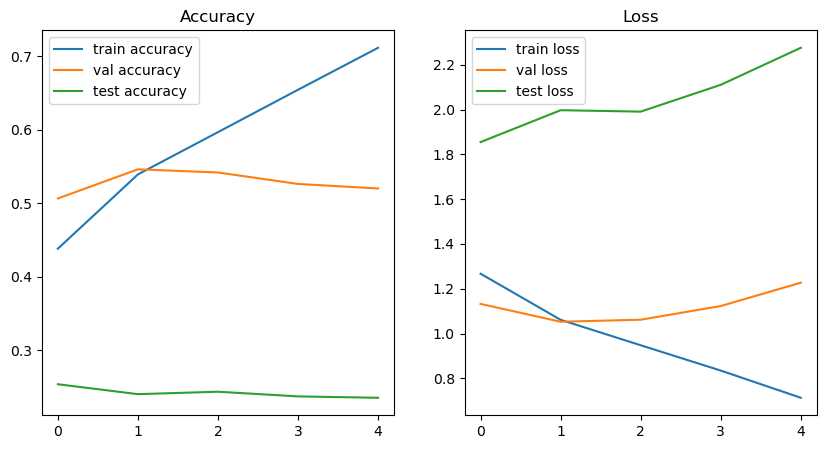

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [16]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 3
bidirectional = True
dropout_rate = 0.2
epochs = 10

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional=True,
    dropout_rate=dropout_rate,
    pad_id = pad_id
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model,  train_dataloader, val_dataloader, test_dataloader, 
               optimizer, criterion, epochs = 5, device = DEVICE)

plot(history)

# Notes

test accuracy not improving. Perhaps the train vocab and test vocab is too different. Try merging train and test tokens. See what happens.